In [7]:
from importlib import reload
import platform, os, sys, datetime, re
import multiprocessing
from os.path import join
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# sys.path.append(join(root_dir,'cvtracer'))
import cvt
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window
from cvt.utils import *

default_settings = dict(
    t_start        = 0,     # Time at which to start tracking, in seconds.
    t_end          = -1,    # Time at which to end tracking, in seconds.
    
    # Background subtraction (for naive background subtraction only).
    bkg_frame_skip = 100,   # Using every frame of the video to compute the background takes a while.
                            # Instead we only use one frame in bkg_frame_skip.
    bkg_sub_amp    = 4,     # Contrast amplification factor applied after background subtraction.
    
    # Contour detection.
    n_pixel_blur   =  7,    # square-root of n-pixels for threshold blurring
    block_size     = 15,    # contour block size
    thresh_offset  = 15,    # threshold offset for contour-finding
    min_area       = 25,    # minimum area for threhold detection
    max_area       = 60,    # maximum area for threhold detection
    RGB            = False, # track in color, false does greyscale
    online_viewer  = False, # Toggle live preview of tracking.

    # What information to draw on the tracking output video.
    video_output_options = dict(tank=True, repeat_contours=False, all_contours=True, 
                                contour_color=(0,200,255), contour_thickness=1, 
                                points=False, directors=True, timestamp=True)
    )

settings_list = list(default_settings.keys()) + \
                ['input_file', 'tracking_dir', 'output_dir', 'trial_file',  
                 'new_input_file', 'bkg_file', 'tank_file', 'settings_file', 
                 'tank_radius', 'ext', 'filename', 'pop', 'age', 'group', 'Nfish', 
                 'Nframes', 'fps', 'fourcc', 'width', 'height']

def create_settings_(input_file, tracking_dir, settings):
    
    globals().update(settings)
    tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8 }
    
    ''' Extract trial info from the filename and the video itself. '''

    filename,ext = os.path.splitext(os.path.basename(input_file))
    pop,_,age,group,Nfish = filename.split('_')[:5]
    Nfish    = int(re.findall('\d+',Nfish)[0])
    age      = int(age[:-3])
    tank_radius = tank_diameter_vs_age[age]/2

    cap      = cv2.VideoCapture(input_file)
    cap.read()
    Nframes  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps      = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc   = int(cap.get(cv2.CAP_PROP_FOURCC))
    width    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    ''' Define and create necessary folders/files/links. '''
    
    output_dir = join(tracking_dir,filename)

    new_input_file = input_file
    if not 'windows' in platform.system().lower():
        new_input_file = join(output_dir,'raw'+ext)
    
    settings_file = join(output_dir,'tracking_settings.txt')
    trial_file    = join(output_dir,'trial.pik')
    tank_file     = join(output_dir,'tank.pik')
    bkg_file      = join(output_dir,f'background-{bkg_frame_skip}.npz')
    
    for k,v in locals().items():
        if k not in ['cap','settings','tank_diameter_vs_age','_']:
            settings[k] = v
        
    return settings


def create_directories(settings):
    for k in 'tracking_dir','output_dir','input_file','new_input_file':
        globals()[k] = settings[k]
    if not os.path.exists(tracking_dir):
        os.mkdir(tracking_dir)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    if not 'windows' in platform.system().lower():
        if not os.path.exists(new_input_file):
            os.symlink(os.path.relpath(input_file,output_dir),new_input_file)
    return


def save_settings(settings):
    with open(settings['settings_file'],'w') as fh:
        for k,v in settings.items():
            print(f'{k} = {v}',file=fh)
    return

# Locate input/output and allocate CPU's

`tracking_dir` sets the top-level output directory. The output of tracking each video will go in `tracking_dir`, in a subdirectory named after the input video file.  

`n_threads` controls the number of tracking tasks to execute simulataneously. `n_threads = None` defaults to the number of CPU's on the machine running the notebook.

`input_files` set the list of video files to perform tracking on.

In [8]:
# tracking_dir = '../tracking/full' # use this one to track full videos
# tracking_dir = '../tracking/partial' # use this one to track small excerpts
tracking_dir = './test/output' # use this one to track small excerpts

def create_settings(input_file,tracking_dir=tracking_dir,settings=default_settings):
    return create_settings_(input_file,tracking_dir,settings)

n_threads = None

# input_files = sorted(glob('../raw_videos/*.avi'))
# input_files = sorted(glob('../raw_videos/*_*_7dpf_*.avi'))

# input_files = []
# for f in sorted(glob('../raw_videos/*.avi')):
#     print(f)
#     settings = create_settings(f)
#     if not os.path.exists(settings['trial_file']):
#         input_files.append(f)
# display(input_files)

input_files = ['./test/input/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70.avi']

# Locate the tanks

In [9]:
for input_file in input_files:
    print(input_file)
    settings = create_settings(input_file)
    create_directories(settings)
    globals().update(settings)
    tank = Tank(r_cm=tank_radius)
    tank.load_or_locate_and_save(tank_file,input_file)

./test/input/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70.avi

        Tank object loaded from ./test/output/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70/tank.pik 


# Compute backgrounds

Compute the background by averaging frames over the entire video. Save it as `background.npy` in the output directory. Use the pre-existing file if there is one.

In [10]:
def subtract_background(frame,bkg,bkg_sub_amp):
    return 255-np.minimum(255,bkg_sub_amp*np.absolute(frame-bkg)).astype(np.uint8)    


def compute_background(settings):
    
    globals().update(settings)
    
    if os.path.exists(bkg_file):
        bkg  = np.load(bkg_file)['bkg']
    else:
        t0    = datetime.datetime.now()
        cap   = cv2.VideoCapture(new_input_file)
        _,frame = cap.read()
        bkg   = np.zeros(frame.shape,dtype=float)
        count = 0
        # If bkg_frame_skip is small (<10) it may be faster to use
        # cap.grab instead of cap.set.
        for n in range(0,Nframes,bkg_frame_skip):
            cap.set(cv2.CAP_PROP_POS_FRAMES,n)
            ret,frame = cap.read()
            bkg      += frame
            count    += 1
        bkg   = bkg / count
        np.savez_compressed(bkg_file,bkg=bkg)
        print(input_file)
        print('Using every {bkg_frame_skip}th frame.')
        print(datetime.datetime.now()-t0)
        sys.stdout.flush()
    
    # Show the background.
    cv2.imwrite(join(output_dir,'background.png'),bkg)
    
    return

#---------------------------------------------------

# Single thread version.
for f in input_files:
    settings = create_settings(f)
    compute_background(settings)

#----

# # Multithread version.
# with multiprocessing.Pool(n_threads) as pool:
#     pool.map(compute_background,[create_settings(f) for f in input_files])

### Track with simple background subtraction

In [13]:
reload(cvt.TrAQ.Trial)
from cvt.TrAQ.Trial import Trial
reload(cvt.TrAQ.CVTracer)
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window




# tweaks = dict(t_start = 4, t_end = 4.5,
tweaks = dict(t_start = 0, t_end = -1,
              n_pixel_blur   =  5,    # square-root of n-pixels for threshold blurring
              block_size     = 15,    # contour block size
              thresh_offset  = 13,    # threshold offset for contour-finding
              min_area       = 10,    # minimum area for threhold detection
              max_area       = 100,   # maximum area for threhold detection
              online_viewer  = False, 
              video_output_options = dict(tank=True, repeat_contours=False, all_contours=True, 
                            contour_color=(0,0,255), contour_thickness=1, 
                            points=False, timestamp=True)
             )

f = input_files[0]
print(input_file)
settings = create_settings(f)
settings.update(tweaks)

save_settings(settings)
globals().update(settings)

trial   = Trial()
trial.init(video_file=new_input_file, output_dir=output_dir, n_ind=Nfish, 
           fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

tracker = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
                   threshold_offset=thresh_offset, min_area=min_area, max_area=max_area, 
                   significant_displacement=2, RGB=True, live_preview=online_viewer)

bkg = np.load(bkg_file)['bkg']

frames_dir = join(output_dir,'frames')

try:
    tracker.set_frame(tracker.frame_start)
    tracker.init_live_preview()
    for i_frame in range(tracker.frame_start, tracker.frame_end+1):
        if tracker.get_frame():
            # Use b to output detailed information about the subset of the frames.
            # Whenever b evaluates to True, images are saved in "[output_dir]/frames" 
            # showing each step of the tracking process.
            b = 260<tracker.frame_num<275 # False # 
            if b:
                if not os.path.exists(frames_dir):
                    os.mkdir(frames_dir)
                cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-1_raw.png'),tracker.frame)
            tracker.frame = subtract_background(tracker.frame,bkg,bkg_sub_amp)
            if b:
                cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-2_subtracted.png'),tracker.frame)
            tracker.mask_tank()
            tracker.detect_contours()
            tracker.connect_frames()
            if b:
                cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-3_masked.png'),tracker.frame)
                tracker.draw(directors=False,**video_output_options)
                cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-4_contours.png'),tracker.frame)
            tracker.draw(directors=True,**video_output_options)
            if b:
                cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-5_directors.png'),tracker.frame)
            tracker.write_frame()
            if not tracker.post_frame(delay=1):
                break
            tracker.print_current_frame()
    tracker.release()
    tracker.trial.save()
except:
    tracker.release()
    %tb


./test/input/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70.avi

        Tank object loaded from ./test/output/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70/tank.pik 
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].
       Current tracking time: 00:00:10:03 
       Video capture released.

        Trial object saved as ./test/output/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70/trial.pik 


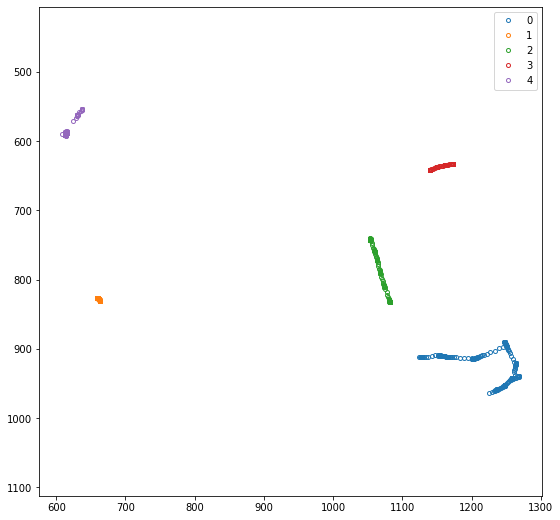

In [15]:
plt.figure(figsize=(9,)*2)
for fish in tracker.df.columns.levels[0]:
    x,y,theta,area = tracker.df[fish].values.T
    plt.plot(x,y,marker='o',ms=4,mfc='None',lw=0,label=str(fish))
plt.axis('equal')
plt.gca().yaxis.set_inverted(True)
plt.legend()
plt.show()

# display(tracker.df.loc[:,(slice(None),['x_px','y_px'])])

# MOG subtraction (older)

In [ ]:
# #==========================================================================
# # Parameter tweaking area.

# t_start,t_end = 60,65 # Times between which to track, in seconds.
# n_pixel_blur  = 3     # square-root of n-pixels for threshold blurring
# block_size    = 15    # contour block size
# thresh_offset = 4     # threshold offset for contour-finding
# min_area      = 30    # minimum area for threhold detection
# max_area      = 100   # maximum area for threhold detection
# online_viewer = True

# video_output_options = dict(tank=True, repeat_contours=False, all_contours=True, 
#                             contour_color=(0,255,0), contour_thickness=1, 
#                             points=False, directors=True, timestamp=True)

# #==========================================================================
# # Actual tracking.

# save_settings()

# trial = Trial()
# trial.init(video_file=new_input_file, output_dir=output_dir, n=Nfish, t=pop, date=date, 
#            fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

# cvt = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
#                threshold_offset=thresh_offset, min_area=min_area, RGB=True,
#                online=online_viewer, 
#                MOG2=True, MOG_history=10000, MOG_initial_skip=500,
#                MOG_varThreshold=35, MOG_learning_rate=0.001)

# try:
#     cvt.set_frame(cvt.frame_start)
#     cvt.init_live_preview()
#     for i_frame in range(cvt.frame_start, cvt.frame_end+1):
#         if cvt.get_frame():
#             cvt.mask_tank()
#             cvt.mask_background()
#             cvt.detect_contours()
#             cvt.analyze_contours()
#             cvt.connect_frames()
#             cvt.update_trial()
#             cvt.draw(**video_output_options)
#             cvt.write_frame()
#             if not cvt.post_frame(delay=1):
#                 break
#             cvt.print_current_frame()
#     cvt.release()
#     cvt.trial.save()
# except:
#     %tb
#     cvt.release()